# 0. Set up

In [1]:
import os
import re
import sys
import time
import pickle
import importlib
import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter

import osmnx as ox 
import networkx as nx
from pyproj import Transformer
from shapely.geometry import Point, Polygon, LineString

from igraph import Graph
import igraph as iG

import plotly as py
import plotly.graph_objs as go
from shapely.ops import unary_union

def reload_module(module):
    importlib.reload(module)

# Specify the directory containing the .py modules
module_dir = "../modules"

# Add the directory to the Python path
sys.path.append(os.path.abspath(module_dir))

In [2]:
def value_formatter(x, pos=None):
    # Format with commas as thousand separators
    return f"{abs(int(x)):,}" if x == int(x) else f"{abs(x):,.2f}"

## Load other relevant resources

In [3]:
from datasets import KnowledgeBase
from map_resources import MapResources

In [66]:
# A wide dataframe for PUBLIC schools that also contain variables that can be used as node attributes
fpath = '../datasets/processed/compiled_public_datasets.csv'
public = pd.read_csv(fpath, index_col='school_id')
# print(public.shape)

# A wide dataframe for PRIVATE schools that also contain variables that can be used as node attributes
fpath = '../datasets/processed/compiled_private_datasets.csv'
private = pd.read_csv(fpath, index_col='school_id')
# print(private.shape)

# Initialize class that also preloads and reorganizes PSGC shapefiles
mr = MapResources(preloaded=True)

# The gpd_gadm is the dataframe of the shapefiles of Philippines following PSGC with EPSG:4326
gpd_gadm = mr.gadm.copy()

# The output is a dictionary of complete filepaths where the keys are the PSGC region names
# of our 17 regions. These are OSMNX drive graph networks
mr.get_filepaths_of_regional_road_networks()

# Additional preprocessing is done on our compiled public & private datasets
gdf_public = mr.preprocess_public_school_coordinates_further(public)
gdf_private = mr.preprocess_private_school_coordinates_further(private)

In [5]:
# Sanity check of ESC participating schools located within Region IV-A
mask = (
    (private['region'].str.contains(r'IV-A'))
    & (private['esc_participating'] == 1)
)
esc_4a = private.loc[mask]

print(esc_4a.shape)

(706, 38)


In [6]:
target_psgc = '0400000000' # Region IV-A
max_depth = 3
geo_results = mr.get_adjacent_geographies(
    gpd_gadm=gpd_gadm, 
    target_psgc=target_psgc, 
    max_depth=max_depth
)

Finding adjacent geographies for PSGC 0400000000 with max_depth=3
Detected administrative level: region
Finding adjacent areas at depth 1...
Found 62 adjacent areas at depth 1
Finding adjacent areas at depth 2...
Found 101 adjacent areas at depth 2
Finding adjacent areas at depth 3...
Found 136 adjacent areas at depth 3
Geography processing completed in 9.32 seconds


# 1. Load Schools Network

In [7]:
%%time
load_path = '../output/gnet_Region4A_07-02-2025.pkl'
with open(load_path, 'rb') as file: # Open the file in binary read mode ('rb')
    results = pickle.load(file) # Load the dictionary from the file

print(results.keys())

dict_keys(['distance_matrix', 'routes', 'master_graph', 'master_graph_4326', 'school_mappings', 'pruned_graph'])
CPU times: user 2.37 s, sys: 800 ms, total: 3.17 s
Wall time: 5.95 s


## 1.1 Inspect network

To see that our locally saved schools network contains vertices and edges, we use iGraph methods.

In [8]:
graph = results['pruned_graph']
vertices = graph.vs
edges = graph.es

print(f"Count of nodes/vertices in our Region IV-A schools network is: {len(vertices):,}")
print(f"Count of edges in our Region IV-A schools network is: {len(edges):,}")

Count of nodes/vertices in our Region IV-A schools network is: 6,148
Count of edges in our Region IV-A schools network is: 393,566


We display a sample node for a public and private school. Note that private school nodes have more attributes than their public school counterparts.

In [9]:
# Public school node
public_school_nodes = [node for node in graph.vs if node['school_attrs'][0]['sector'] == 'Public']
display(public_school_nodes[0])

igraph.Vertex(<igraph.Graph object at 0x7f08d0b35650>, 0, {'school_id': 101583, 'school_type': 'public', 'school_name': 'Dorongan ES', 'x': 560327.2979985776, 'y': 1600265.3025909872, 'school_attrs': [{'region': 'Region I', 'division': 'Pangasinan I, Lingayen', 'school_name': 'Dorongan ES', 'province': 'PANGASINAN', 'municipality': 'MANGATAREM', 'longitude': 121.5609412, 'latitude': 14.4687248, 'shifting_schedule': 'No Shift', 'modified coc': 'Purely ES', 'seats_es': 67.0, 'seats_jhs': nan, 'seats_shs': nan, 'enrollment_es': 181.0, 'enrollment_jhs': nan, 'enrollment_shs': nan, 'shs_ABM': nan, 'shs_ARTS & DESIGN': nan, 'shs_GAS': nan, 'shs_HUMSS': nan, 'shs_PBM': nan, 'shs_SPORTS': nan, 'shs_STEM': nan, 'shs_TVL': nan, 'sector': 'Public', 'x': 560327.2979985776, 'y': 1600265.3025909872}], 'is_school': True})

In [10]:
# Private school node
private_school_nodes = [node for node in graph.vs if node['school_attrs'][0]['sector'] == 'Private']
display(private_school_nodes[0])

igraph.Vertex(<igraph.Graph object at 0x7f08d0b35650>, 3655, {'school_id': 400395, 'school_type': 'private', 'school_name': 'Acacia School Foundation, Inc', 'x': 508749.29046636156, 'y': 1574179.26249036, 'school_attrs': [{'region': 'Region IV-A', 'division': 'Sta. Rosa City', 'school_name': 'Acacia School Foundation, Inc', 'province': 'LAGUNA', 'municipality': 'CITY OF SANTA ROSA', 'barangay': 'DON JOSE', 'school type': 'Mother school', 'modified coc': 'All Offering', 'enrollment_es': 139.0, 'enrollment_jhs': 51.0, 'enrollment_shs': 18.0, 'seats_kinder': 123.0, 'seats_es': 53.0, 'seats_jhs': 70.0, 'seats_shs': 18.0, 'esc_participating': nan, 'shsvp_participating': nan, 'esc_school_id': nan, 'esc_(tuition)': nan, 'esc_(other)': nan, 'esc_(misc)': nan, 'esc_(total)': nan, 'shsvp_(tuition)': nan, 'shsvp_(other)': nan, 'shsvp_(misc)': nan, 'shsvp_(total)': nan, 'esc_amount': nan, 'shs_ABM': 0.0, 'shs_ARTS & DESIGN': 0.0, 'shs_GAS': 1.0, 'shs_HUMSS': 0.0, 'shs_PBM': 0.0, 'shs_SPORTS': 0.0,

# 2. Use Cases
* * *
1. ECAIR version of suggested ESC and SHSVP subsidy amount
2. Absorptive Cap of ESC grantees and SHSVP per private schools 
3. How many public junior high schools are on shifting sched and congested? 
4. How many ESC vouchers are needed per region?
5. How many are excess learners in public elementary and JHS schools with regard to the absorptive, seats, rooms?
6. How many public elem grad can avail the top up amount once qualified in the ESC program? Same question for SHSVP

## 2.1. Subsidy amounts
We will suggest subsidy amounts by computing an approximate value based on the tuition fees of ESC and SHS VP participating schools that are **nearby** our public and private schools. A subsidy participating school is considered **nearby** when their **road distance** to a public or private school is less than or equal to a predefined distance threshhold. For this use case, we use a distance threshhold of 5,000 meters (or 5 kilometers).

### 2.1.1. ESC

#### Subgraph generation

In [33]:
# We display the unique values of our modified coc attribute as reference
set([node['school_attrs'][0]['modified coc'] for node in graph.vs])

{'All Offering',
 'ES and JHS',
 'JHS with SHS',
 'Purely ES',
 'Purely JHS',
 'Purely SHS',
 nan}

We isolate from our schools network our `feeder` and `ESC participating schools`. `Feeder` schools are public or private schools that offer Elementary and whose students can become beneficiaries of ESC to study in private `ESC participating schools`.

In [34]:
feeder_node_indices = [] # list to store the node index of feeder schools
esc_node_indices = [] # list to store the node index of esc participating schools

get_attrs = lambda node: node['school_attrs'][0]
for node in graph.vs:
    node_idx = node.index
    sector = get_attrs(node)['sector']
    coc = get_attrs(node)['modified coc']
    esc_participating = get_attrs(node).get('esc_participating')

    # Filter for feeders (public and private)
    if coc in ['All Offering','ES and JHS','Purely ES']:
        feeder_node_indices.append(node_idx)

    # Filter for esc participating schools (private only)
    if esc_participating == 1 and coc in ['All Offering','ES and JHS','JHS with SHS','Purely JHS']:
        esc_node_indices.append(node_idx)

    # NOTE: Feeder schools can also be ESC participating schools

print(f"Count of feeder nodes: {len(feeder_node_indices):,}")
print(f"Count of esc participating nodes: {len(esc_node_indices):,}")

Count of feeder nodes: 4,970
Count of esc participating nodes: 669


We then generate a subgraph from our larger schools network to only include edges whose nodes are feeders and/or ESC participating. We further filter our valid edges using a road distance threshold to simulate a distance constraint.

In [35]:
%%time
valid_edges = []
distance_threshold = 5_000

for edge in graph.es:
    source, target = edge.tuple
    edge_length = edge['length']
    edge_idx = edge.index

    if (source in feeder_node_indices and target in esc_node_indices) \
    or (source in esc_node_indices and target in feeder_node_indices):
        if edge_length <= distance_threshold:
            valid_edges.append(edge_idx)

print(f"Count of valid edges within distance threshold: {len(valid_edges):,}")

subgraph_esc = graph.subgraph_edges(valid_edges, delete_vertices=True)

Count of valid edges within distance threshold: 50,536
CPU times: user 10.3 s, sys: 0 ns, total: 10.3 s
Wall time: 10.3 s


#### Subgraph visualization

In [36]:
# Set up plotting aesthetics
visual_style = {}

# Add the vertex_shape to visual_style
vertex_shapes = []
for node in subgraph_esc.vs:
    if node.index in feeder_node_indices and node.index in esc_node_indices:
        vertex_shapes.append("diamond")
    elif node.index in feeder_node_indices and node.index not in esc_node_indices:
        vertex_shapes.append("square")
    elif node.index not in feeder_node_indices and node.index in esc_node_indices:
        vetex_shapes.append("triangle")
        
visual_style["vertex_shape"] = vertex_shapes

# Set node colors based on type (blue for public, red for private)
vertex_colors = []
for node in subgraph_esc.vs:
    if get_attrs(node)['sector'] == "Public":
        vertex_colors.append("forestgreen")
    elif get_attrs(node)['sector'] == "Private":
        if get_attrs(node)['esc_participating'] == 1:
            vertex_colors.append("gold")
        elif str(get_attrs(node)['esc_participating']) in ['0','nan']:
            vertex_colors.append("grey")

visual_style["vertex_color"] = vertex_colors

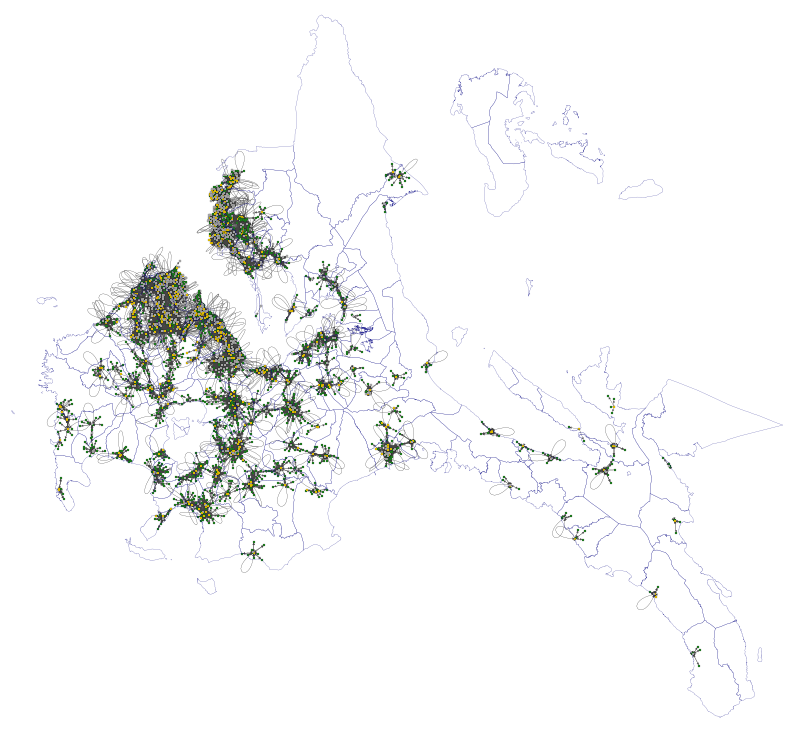

CPU times: user 28.5 s, sys: 901 ms, total: 29.4 s
Wall time: 29.3 s


In [37]:
%%time
fig, ax = plt.subplots(figsize=(10,10))

mult_savefig = 1
# Plot network anchored on the schools' lon-lat
iG.plot(
    subgraph_esc,
    target=ax,
    **visual_style,
    vertex_size=2*mult_savefig,
    vertex_frame_width=.1,
    edge_width=.1,           # Make edges thicker
    edge_arrow_size=2*mult_savefig,      # Control arrow size
    edge_arrow_width=2*mult_savefig,     # Control arrow width
    # bbox=(1000,1000),
    # margin=0
)

shape_4a = (
    geo_results['target_area']
    .dissolve(by='adm3_psgc')
    .to_crs(3123)
)

shape_4a.plot(
    ax=ax, facecolor='none', edgecolor='navy',
    linewidth=.15, alpha=.8,
)

cm_3123_shp = shape_4a.unary_union # This is 4326

min_x, min_y, max_x, max_y = cm_3123_shp.bounds
multiplier = 0.001
ax.set_xlim(min_x*(1 - multiplier), max_x*(1 + multiplier))
ax.set_ylim(min_y*(1 - multiplier), max_y*(1 + multiplier))

# plt.savefig(
#     '../output/region4a_esc_network.svg',
#     dpi=300, transparent=True, bbox_inches='tight',
# )

plt.show()
plt.close()

#### Computation using subgraph
We generate a tabular dataset using our subgraph's edges and node attributes. **Every row in the tabular dataset is an edge** that shows handpicked attributes from the edge's source (origin/feeder) and target (ESC participating school) node.

In [38]:
df_data = []
for edge in subgraph_esc.es:
    source, target = edge.tuple
    edge_length = edge['length']

    src_sch_id = subgraph_esc.vs[source]['school_id']
    src_sector = get_attrs(subgraph_esc.vs[source])['sector']
    src_region = get_attrs(subgraph_esc.vs[source])['region']

    tr_sch_id = subgraph_esc.vs[target]['school_id']
    tr_sector = get_attrs(subgraph_esc.vs[target])['sector']
    tr_region = get_attrs(subgraph_esc.vs[target])['region']
    tr_jhs_tuition = get_attrs(subgraph_esc.vs[target]).get('esc_(total)')

    row_values = [
        src_sch_id, src_sector, src_region,
        tr_sch_id, tr_sector, tr_region, tr_jhs_tuition,
        edge_length
     ]
    df_data.append(row_values)

df_data = np.array(df_data)

df_columns = [
    'origin_school_id',
    'origin_sector',
    'origin_region',
    'destination_school_id',
    'destination_sector',
    'destination_region',
    'destination_jhs_tuition',
    'schools_distance'
]
df_esc = pd.DataFrame(
    data=df_data,
    columns=df_columns
)

In [40]:
# We display the first 5 rows
df_esc.head()

,origin_school_id,origin_sector,origin_region,destination_school_id,destination_sector,destination_region,destination_jhs_tuition,schools_distance
0,107329,Public,Region IV-A,401582,Private,Region IV-A,22845.5,4195.997
1,107329,Public,Region IV-A,401581,Private,Region IV-A,15500.0,4150.419
2,107334,Public,Region IV-A,401582,Private,Region IV-A,22845.5,2673.929
3,107334,Public,Region IV-A,401581,Private,Region IV-A,15500.0,2492.942
4,107319,Public,Region IV-A,401582,Private,Region IV-A,22845.5,881.589


We display the distribution of the JHS tuition fees of ESC participating schools that are **nearby** our feeder schools. Nearby here would mean an ESC participating school is less than or equal to 5,000 kilometers away from a feeder school.

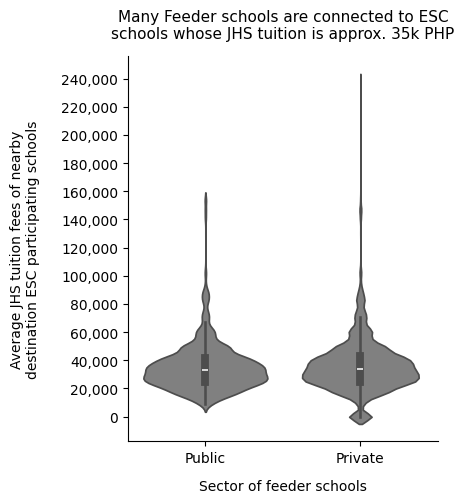

In [42]:
fig, ax = plt.subplots(figsize=(4,5))

sns.violinplot(
    x='origin_sector',
    y='destination_jhs_tuition',
    data=df_esc,
    color='grey'
)

ax.set_ylabel(
    "Average JHS tuition fees of nearby\ndestination ESC participating schools",
    labelpad=15
)
ax.set_xlabel(
    "Sector of feeder schools",
    labelpad=10
)

ax.spines[['top','right']].set_visible(False)
ax.yaxis.set_major_formatter(FuncFormatter(value_formatter))
ax.set_yticks(np.arange(df_esc['destination_jhs_tuition'].min(), 250_000 + 1, 20_000))
ax.set_title(
    'Many Feeder schools are connected to ESC\nschools whose JHS tuition is approx. 35k PHP',
    size=11, y=1.025
)

plt.show()
plt.close()

The following are plausible interpretations of the plot:
1. There is a high concentration of feeder schools connected to ESC participating schools whose JHS tuition fees lie between 20,000 and 40,000 PHP.
2. On average, learners from these feeder schools would have to shell out 11,000 to 31,000 PHP to cover for the balance the current ESC subsidy amount (i.e., 9,000 or 11,000) cannot cover.
3. Based on FIES 2023 data, the median household expenditure on education in Region IV-A is 0 PHP, indicating that half of all households in the region allocate no funds toward educational expenses. This suggests severely limited financial capacity among households to supplement the current ESC subsidy amount. Consequently, these households would likely need to absorb the full balance of any educational costs not covered by the ESC subsidy, potentially creating a significant financial burden that may limit access to quality education.

### 2.1.2. SHS VP
We make slight tweaks to the code we used for ESC to fit SHS VP's context.

In [43]:
# We display the unique values of our modified coc attribute as reference
set([node['school_attrs'][0]['modified coc'] for node in graph.vs])

{'All Offering',
 'ES and JHS',
 'JHS with SHS',
 'Purely ES',
 'Purely JHS',
 'Purely SHS',
 nan}

In [76]:
feeder_node_indices = [] # list to store the node index of feeder schools
shsvp_node_indices = [] # list to store the node index of esc participating schools

get_attrs = lambda node: node['school_attrs'][0]
for node in graph.vs:
    node_idx = node.index
    sector = get_attrs(node)['sector']
    coc = get_attrs(node)['modified coc']
    shsvp_participating = get_attrs(node).get('shsvp_participating')

    # Filter for feeder
    if coc in ['All Offering','ES and JHS','JHS with SHS','Purely JHS']:
        feeder_node_indices.append(node_idx)

    # Filter for esc participating schools
    if shsvp_participating == 1 and coc in ['All Offering','JHS with SHS','Purely SHS']:
        shsvp_node_indices.append(node_idx)

    # NOTE: Feeder schools can also be ESC participating schools

print(f"Count of feeder nodes: {len(feeder_node_indices):,}")
print(f"Count of shsvp participating nodes: {len(shsvp_node_indices):,}")

Count of feeder nodes: 2,074
Count of shsvp participating nodes: 785


In [77]:
%%time
valid_edges = []
distance_threshold = 5_000

for edge in graph.es:
    source, target = edge.tuple
    edge_length = edge['length']
    edge_idx = edge.index

    if (source in feeder_node_indices and target in shsvp_node_indices) \
    or (source in shsvp_node_indices and target in feeder_node_indices):
        if edge_length <= distance_threshold:
            valid_edges.append(edge_idx)

print(f"Count of valid edges within distance threshold: {len(valid_edges):,}")

subgraph_shsvp = graph.subgraph_edges(valid_edges, delete_vertices=True)

Count of valid edges within distance threshold: 28,184
CPU times: user 6.31 s, sys: 0 ns, total: 6.31 s
Wall time: 6.31 s


In [78]:
df_data = []
for edge in subgraph_shsvp.es:
    source, target = edge.tuple
    edge_length = edge['length']

    src_sch_id = subgraph_shsvp.vs[source]['school_id']
    src_sector = get_attrs(subgraph_shsvp.vs[source])['sector']
    src_region = get_attrs(subgraph_shsvp.vs[source])['region']

    tr_sch_id = subgraph_shsvp.vs[target]['school_id']
    tr_sector = get_attrs(subgraph_shsvp.vs[target])['sector']
    tr_region = get_attrs(subgraph_shsvp.vs[target])['region']
    tr_shs_tuition = get_attrs(subgraph_shsvp.vs[target]).get('shsvp_(total)')

    row_values = [
        src_sch_id, src_sector, src_region,
        tr_sch_id, tr_sector, tr_region, tr_shs_tuition,
        edge_length
     ]
    df_data.append(row_values)

df_data = np.array(df_data)

df_columns = [
    'origin_school_id',
    'origin_sector',
    'origin_region',
    'destination_school_id',
    'destination_sector',
    'destination_region',
    'destination_shs_tuition',
    'schools_distance'
]
df_shsvp = pd.DataFrame(
    data=df_data,
    columns=df_columns
)

In [79]:
# We display the first 5 rows
df_shsvp.head()

,origin_school_id,origin_sector,origin_region,destination_school_id,destination_sector,destination_region,destination_shs_tuition,schools_distance
0,307709,Public,Region IV-A,401582,Private,Region IV-A,17500.0,1904.638
1,307709,Public,Region IV-A,409739,Private,Region IV-A,17500.0,247.794
2,307709,Public,Region IV-A,402025,Private,Region IV-A,19300.0,3504.935
3,301072,Public,Region IV-A,410115,Private,Region IV-A,17500.0,2266.098
4,301115,Public,Region IV-A,401609,Private,Region IV-A,29575.0,713.092


In [80]:
df_shsvp['destination_shs_tuition'].mean()

31131.90751652851

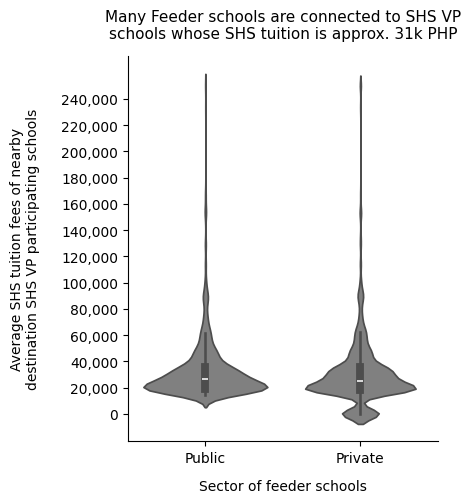

In [54]:
fig, ax = plt.subplots(figsize=(4,5))

sns.violinplot(
    x='origin_sector',
    y='destination_shs_tuition',
    data=df_shsvp,
    color='grey'
)

ax.set_ylabel(
    "Average SHS tuition fees of nearby\ndestination SHS VP participating schools",
    labelpad=15
)
ax.set_xlabel(
    "Sector of feeder schools",
    labelpad=10
)

ax.spines[['top','right']].set_visible(False)
ax.yaxis.set_major_formatter(FuncFormatter(value_formatter))
ax.set_yticks(np.arange(df_shsvp['destination_shs_tuition'].min(), 250_000 + 1, 20_000))
ax.set_title(
    'Many Feeder schools are connected to SHS VP\nschools whose SHS tuition is approx. 31k PHP',
    size=11, y=1.025
)

plt.show()
plt.close()

## 2.2. Access to SHS strands/tracks
For this use case, we mainly answer the question, "What or where are our public schools that has the least access to SHS strands and/or tracks?"

In [81]:
# We extract the relevant node attributes for this use case
shs_offs = [attr for attr in graph.vs[0].attributes()['school_attrs'][0] if "shs_" in attr]
print(shs_offs)

['shs_ABM', 'shs_ARTS & DESIGN', 'shs_GAS', 'shs_HUMSS', 'shs_PBM', 'shs_SPORTS', 'shs_STEM', 'shs_TVL']


In [82]:
%%time
public_jhs_least_access = {}

# We are using the valid edges from our df_shsvp
unique_source_idxs = list(set([graph.es[idx].tuple[0] for idx in valid_edges]))

# We iterate over our feeder schools
for src_idx in unique_source_idxs:
    scr_sch_id = graph.vs[src_idx]['school_id']

    # We get the edges where our feeder school is a source and whose target is a SHS delivering school
    src_edge_idxs = [idx for idx in valid_edges if graph.es[idx].tuple[0] == src_idx]

    public_jhs_least_access[scr_sch_id] = {}

    tmp_dict = {}
    for idx in src_edge_idxs:
        src_i, trgt_i = graph.es[idx].tuple
        _, trgt_node = graph.vs[src_i], graph.vs[trgt_i]

        # A target that offers an SHS strand would have 1 as a value for an offering (e.g., shs_ABM == 1.0)
        for off in shs_offs:
            off_val = trgt_node['school_attrs'][0].get(off)
            val = 0 if str(off_val) == 'nan' else off_val
            # print(off, off_val, val)
            # display(cnt_dict)
            if tmp_dict.get(off):
                tmp_dict[off] += val
            else:
                tmp_dict[off] = val

    public_jhs_least_access[scr_sch_id].update(tmp_dict)
    # break

CPU times: user 26.9 s, sys: 0 ns, total: 26.9 s
Wall time: 26.9 s


In [83]:
jhs_access_to_shs_offerings = pd.DataFrame(data=public_jhs_least_access).T
jhs_access_to_shs_offerings['total_count'] = jhs_access_to_shs_offerings.sum(axis=1)
jhs_access_to_shs_offerings = jhs_access_to_shs_offerings.sort_values(by='total_count', ascending=True)

jhs_least_access = jhs_access_to_shs_offerings[jhs_access_to_shs_offerings['total_count'] < 8]

In [84]:
display(jhs_access_to_shs_offerings.head(2))
display(jhs_access_to_shs_offerings.tail(2))

,shs_ABM,shs_ARTS & DESIGN,shs_GAS,shs_HUMSS,shs_PBM,shs_SPORTS,shs_STEM,shs_TVL,total_count
409010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,shs_ABM,shs_ARTS & DESIGN,shs_GAS,shs_HUMSS,shs_PBM,shs_SPORTS,shs_STEM,shs_TVL,total_count
424152,43.0,0.0,20.0,33.0,0.0,0.0,34.0,22.0,152.0
401865,45.0,1.0,21.0,35.0,0.0,0.0,37.0,23.0,162.0


In [97]:
topic_schools = pd.concat(
    [
        gdf_public[gdf_public.index.isin(jhs_access_to_shs_offerings.index)],
        # gdf_private[gdf_private.index.isin(jhs_access_to_shs_offerings.index)]
    ]
)
least_schools = pd.concat(
    [
        gdf_public[gdf_public.index.isin(jhs_least_access.index)],
        # gdf_private[gdf_private.index.isin(jhs_least_access.index)]
    ]
)
print(topic_schools.shape)
print(least_schools.shape)

(466, 25)
(159, 25)


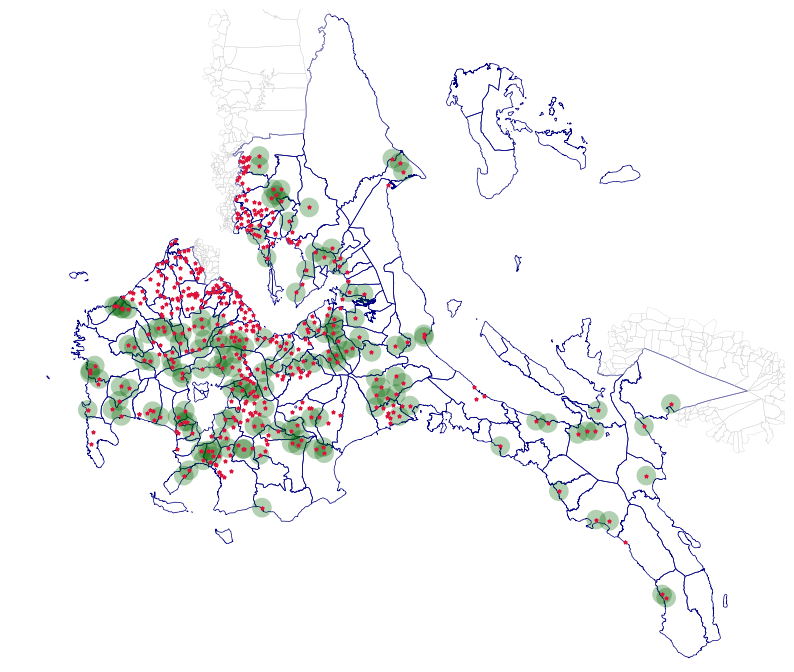

In [98]:
mult_savefig = 2
# Sanity check if our edges are plottable
fig, ax = plt.subplots(figsize=(10,10))

gdf_plot = geo_results['target_area'].copy()

gdf_plot.dissolve(by="adm3_psgc").plot(
    ax=ax, facecolor='none', edgecolor='navy',
    linewidth=.5, alpha=1,
)

for k, v in geo_results['adjacent_areas'].items():
    df_adj = geo_results['adjacent_areas'].get(k)
    df_adj.plot(
        ax=ax, facecolor='none', edgecolor='lightgrey',
        linewidth=.25
    )

topic_schools.plot(
    ax=ax,
    marker='*', markersize=3*mult_savefig, color='crimson',
    zorder=4,
)
least_schools.plot(
    ax=ax,
    marker='o', markersize=100*mult_savefig,
    facecolor='darkgreen',
    edgecolor='none',
    alpha=.3, zorder=3,
)
# dest_priv_schools.plot(
#     ax=ax,
#     marker='d', markersize=6*mult_savefig, color='navy',
#     zorder=2, alpha=.5, edgecolor='none',
# )

df_cm = geo_results['target_area'].copy()
cm_shp = df_cm.unary_union # This is 4326

min_x, min_y, max_x, max_y = cm_shp.bounds
multiplier = 0.001
ax.set_xlim(min_x*(1 - multiplier), max_x*(1 + multiplier))
ax.set_ylim(min_y*(1 - multiplier), max_y*(1 + multiplier))

ax.axis('off')

# plt.savefig(
#     '../output/up_pascn/rizal_access_to_shs_offerings.png',
#     dpi=400, transparent=True, bbox_inches ='tight',
# )

plt.show()
plt.close()